<a href="https://colab.research.google.com/github/ibombonato/aicrowd-blitz-faceimages/blob/main/C%C3%B3pia_de_Getting_Starter_Notebook_for_Mask_Recognition_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Feb 19 17:31:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

![](https://images.aicrowd.com/raw_images/challenges/banner_file/1020/efe95338563ab47dda7e.png)

<h2><center> Getting Started with Mask Recognition Challenge</center></h2>

In this puzzle, we have detect mask type and bounding box of the mask from the image of human face. 

This is a starter kit explaining how to download the data and also submit direcly via this notebook. 

We will be submitting the sample prediction directly in the required format.



 AIcrowd code utilities for downloading data for Language Classification


# Download the files 💾¶
## Download AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [ ]:
!pip install aicrowd-cli

In [ ]:
!pip install --upgrade fastai


## Login to AIcrowd ㊗¶


In [2]:
%load_ext aicrowd.magic
%aicrowd login

Please login here: https://api.aicrowd.com/auth/fiqIBJKRBhgZLiSB11kER6LoK6ONfUFmN4Vp1jzjkxc
API Key valid
Gitlab access token valid
Saved details successfully!



## Download Dataset¶

We will create a folder name data and download the files there.


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c mask-prediction -o data

sample_submission.csv:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/115M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/193k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/318M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/137M [00:00<?, ?B/s]

In [4]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

## Diving in the dataset 🕵️‍♂️

In [16]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from tqdm.auto import tqdm
import shutil
tqdm.pandas()

## Diving in the dataset 🕵️‍♂️

In [6]:
train_images = 'data/train'
val_images = 'data/val'
test_images = 'data/test'

In [7]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

In [8]:
train_df.head()

,ImageID,bbox,masktype
0,k8o0f,"[73, 197, 293, 400]",N95
1,7a0l9,"[47, 364, 300, 512]",surgical
2,wfp7p,"[203, 221, 380, 403]",N95
3,7qaw6,"[87, 210, 322, 385]",surgical
4,i4kqj,"[227, 283, 479, 475]",surgical


In [18]:
from pathlib import Path
import os

def create_dirs(labels, splits):
  for split in splits:
    for label in labels:
      os.makedirs(f"/content/images/{split}/{label}/", exist_ok=True)

def image_to_label_folder(img_name, label_directory, split_directory):
  origin = Path(f"/content/data/{split_directory}/{split_directory}/{img_name}.jpg")
  target = Path(f"/content/images/{split_directory}/{label_directory}/{img_name}.jpg")
  shutil.copy(origin, target)

def move_images(df, split):
  df.progress_apply(lambda x: image_to_label_folder(x["ImageID"],x["masktype"], split), axis=1)

In [10]:
labels = train_df['masktype'].unique()

create_dirs(labels, ["train", "val"])

In [19]:
move_images(train_df, "train")
move_images(val_df, "val")

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

## Predicting Mask Type

In [20]:
from fastai.vision.all import *
path = '/content/images'

dls = ImageDataLoaders.from_folder(
    path, train='train', valid='val', item_tfms=Resize(224), 
                                        batch_tfms=aug_transforms(size=224))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [26]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.to_fp16()

SuggestedLRs(valley=0.0012022644514217973)

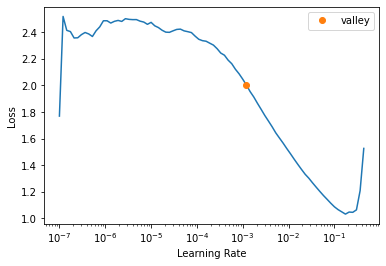

In [27]:
learn.lr_find()

In [28]:
learn.fine_tune(3, 0.0012022644514217973)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.589937,0.081890,0.031667,0.968333,01:11


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.047582,0.010307,0.003750,0.996250,01:13
1,0.020195,0.011425,0.003333,0.996667,01:11
2,0.006074,0.009365,0.003333,0.996667,01:12


## Pred Mask

In [30]:
# Image Reading & Preprocessing
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [31]:
def gen_bounding_boxes_and_mask(img):

  # Converting the image to numpy array 
  np_img = np.array(img)
  gray = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)

  # Getting the edges
  canny = cv2.Canny(gray, 100, 200)

  # Getting the contours
  contours, hierarchy = cv2.findContours(canny, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # Sorting the contours
  contours = sorted(contours, key=cv2.contourArea)

  try:
    # Return the boundong boxes of the biggest contour
    x,y,w,h = list(cv2.boundingRect(contours[-1])) 
  # Incase no countous found
  except:
    x,y,w,h = [1, 1, 1, 1]
  left,top,right, bottom = x,y,x+w,y+h
  mask = img.crop((left,top,right, bottom))

  return x,y,w,h, mask

In [32]:
def preprocessor(image_path, df):

  dataframe = df.copy()
  bboxes = []
  image_ids = []
  mask_type = []
  # Ground through each test image
  # for i in range(len(df_list)):
  for i in tqdm(range(dataframe.shape[0])):
    # Reading the test image
    img = Image.open(os.path.join(image_path, list(dataframe['ImageID'])[i]+'.jpg'))

    # Generating the bounding boxes
    x,y,w,h,mask = gen_bounding_boxes_and_mask(img)

    #Convert to grayscale
    mask = mask.convert('L')

    #Reshapes the image to a fix sahpe -> 190×190(You can choose any shape)
    mask = mask.resize((190,190))
    mask = np.asarray(mask)

    #Squeezes the matrix for feeding the value to model
    mask = np.squeeze(mask[10,:])
 

    mask_type.append(mask)
    
    # Adding the boundong boxes and image id
    bboxes.append([x,y,x+w,y+h])
    # image_ids.append(test_imgs[i].split(".")[0])
  if image_path == test_images:
      dataframe['bbox'] = bboxes
  else:
      dataframe['pred_bbox'] = bboxes
  dataframe['imgData'] = mask_type
  return dataframe

In [ ]:
TEST_IMAGE_PATH = "/content/data/test/test/"
test_df = pd.DataFrame()
n_test_image = os.listdir(TEST_IMAGE_PATH)

test_df['ImageID'] = [img_name.split(".")[0] for img_name in n_test_image]

test_df = preprocessor(TEST_IMAGE_PATH, test_df)

test_df.head()

In [40]:
test_df['image'] = test_df['ImageID'].apply(lambda x: f"/content/data/test/test/{x}.jpg")

In [41]:
test_dl_df = dls.test_dl(test_df['image'])

In [43]:
preds_test_df = learn.get_preds(dl=test_dl_df)
labelled_preds = [learn.dls.vocab[pred.argmax()] for pred in preds_test_df[0]]

In [44]:
test_df['masktype'] = labelled_preds

In [49]:
test_df.head()

,ImageID,bbox,masktype
0,hm3nl,"[266, 137, 495, 404]",N95
1,6bbrv,"[88, 103, 245, 248]",KN95
2,1sa11,"[85, 286, 370, 512]",KN95
3,astz6,"[288, 16, 512, 152]",cloth
4,iaxwc,"[285, 429, 319, 484]",cloth


In [47]:
test_df.drop(['imgData', 'image'], axis=1, inplace = True)
test_df.rename(columns = {'pred_bbox':'bbox'}, inplace = True)
test_df.head()

,ImageID,pred_bbox,masktype
0,hm3nl,"[266, 137, 495, 404]",N95
1,6bbrv,"[88, 103, 245, 248]",KN95
2,1sa11,"[85, 286, 370, 512]",KN95
3,astz6,"[288, 16, 512, 152]",cloth
4,iaxwc,"[285, 429, 319, 484]",cloth


## Generating Prediction File

In this starter kit we will directly be submitting the sample prediction file. In case you would like to see a submission via baseline model, check it out here. 

In [50]:
!rm -rf assets
!mkdir assets
test_df.to_csv(os.path.join("assets", "submission.csv"), index=False)


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [51]:
%aicrowd notebook submit -c mask-prediction -a assets --no-verify

Using notebook: Cópia de Getting Starter Notebook for Mask Recognition Challenge for submission...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                   
                                                  │ Successfully submitted! │                                                   
                                                  ╰─────────────────────────╯

                                                        Important links                                                         
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/submissions/174550              │
│                  │                                                                                                           │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/submissions?my_submissions=true │
│                  │                                                                                                           │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/leaderboards                    │
│                  │                                                                                                           │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xiii                                                             │
│                  │                                                                                                           │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction                                 │
└──────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────┘